# Problem:
Given a potts model like so:
$\begin{array}{c|cc}
  & A & B \\
\hline      
A & AA & AB \\
B & AB & BB 
\end{array}$,
arrays are of the form$
\begin{pmatrix}
AA & AB & 0 & \dots \\
AB & BB & 0 & \dots \\
0  & 0  & 0 & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}$, where they are padded out to the batch size. Note that the matrix will never need to be truncated at this point because it will be padded to, at max, the max sequence length in the batch. The padded dimensions of the matrix are the same length as the sequence that it represents.

The arrays need to be of the form
$\begin{pmatrix}
\vdots & \vdots & \vdots \\
0  & AB & 0 & \dots \\
AA & BB & 0 & \dots \\
AB & 0  & 0 & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}$, where the matrix is still padded to batch_size column-wize, but centered on the residue corresponding to the column at the specific time-step in a window that is padded out to $receptive\_field*2 - 1$. Note that the matrix may need to be truncated here is the receptive field is less than $receptive\_field \lt seq\_len$

In [68]:
from rgn.model.net_ops import read_protein
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()
sess = tf.Session()

num_evo_entries = 20
NUM_DIMENSIONS = 3
NUM_AAS = 20
max_length = 700
num_edge_residues = 0

In [205]:
def read_protein(max_length, num_edge_residues, num_evo_entries, name=None):
    def _read(serialized_example):
        with tf.name_scope(name, 'read_protein', []) as scope:
            # Parse TF Record
            context, features = tf.parse_single_sequence_example(serialized_example,
                                    context_features={
                                        'id':      tf.FixedLenFeature((1,), tf.string)
                                    },
                                    sequence_features={
                                        'primary':      tf.FixedLenSequenceFeature((1,),               tf.int64),
                                        'evolutionary': tf.FixedLenSequenceFeature((num_evo_entries,), tf.float32, allow_missing=True),
                                        'secondary':    tf.FixedLenSequenceFeature((1,),               tf.int64,   allow_missing=True),
                                        'tertiary':     tf.FixedLenSequenceFeature((NUM_DIMENSIONS,),  tf.float32, allow_missing=True),
                                        'mask':         tf.FixedLenSequenceFeature((1,),               tf.float32, allow_missing=True),
                                        'coevolutionary':tf.FixedLenSequenceFeature((21, 21),          tf.float32, allow_missing=True)
                                    })
            id_ =                   context['id'][0]
            primary =   tf.to_int32(features['primary'][:, 0])
            evolutionary =          features['evolutionary']
            secondary = tf.to_int32(features['secondary'][:, 0])
            tertiary =              features['tertiary']
            mask =                  features['mask'][:, 0]
            seq_len = tf.shape(primary)[0]
            coevolutionary_raw = tf.reshape(features['coevolutionary'], (seq_len, seq_len, 21, 21))
            
            # preform frobenius normalization and average product correction (APC) on the raw outputs from CCMPred.
            # operations can be found in section 1.1 of the supplimentary material from the CCMPred paper:
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4201158/
            # preform frobenius normalizarion on the edge potentials
            frobenius = tf.square(coevolutionary_raw)
            frobenius = tf.reduce_sum(frobenius[:, :, :20, :20], axis=(2, 3))
            frobenius = tf.sqrt(frobenius)
            # preform APC to arriva at the final "C_ij" contact potential score
            S_i = tf.reduce_sum(frobenius, (0,))[:, tf.newaxis]
            S_j = tf.reduce_sum(frobenius, (1,))[tf.newaxis, :]
            S = tf.reduce_sum(frobenius)
            apc = frobenius - ((S_i * S_j) / S)
            # set diagonal to 0 by subtracting a matrix of 0s with the diagonal set to that of the apc matrix
            coevolutionary = apc - tf.linalg.set_diag(tf.zeros(tf.shape(apc)), tf.linalg.diag_part(apc))
            
            # Predicate for when to retain protein
            pri_length = tf.size(primary)
            keep = pri_length <= max_length

            # Convert primary to one-hot
            one_hot_primary = tf.one_hot(primary, NUM_AAS)

            # Generate tertiary masking matrix. If mask is missing then assume all residues are present
            mask = tf.cond(tf.not_equal(tf.size(mask), 0), lambda: mask, lambda: tf.ones([pri_length - num_edge_residues]))
            ter_mask = mask  # masking_matrix(mask, name='ter_mask')        

            # Return tuple
            return id_, one_hot_primary, evolutionary, coevolutionary_raw, coevolutionary, secondary
    return _read
# ----------------------------------------------------------------------------------------------
dataset = tf.data.TFRecordDataset([f'C:/Users/wlgfo/Desktop/hms/tfrecord/sample_prot.tfrecord-{i}' for i in range(40)])
dataset = dataset.map(read_protein(max_length, num_edge_residues, num_evo_entries))
dataset = dataset.padded_batch(40, ([], [-1, 21], [-1, 20], [-1, -1, 21, 21], [-1, -1], [-1]))

# Normal read and process

<
(631, 106, 1, 21, 21)
(631, 106, 1)


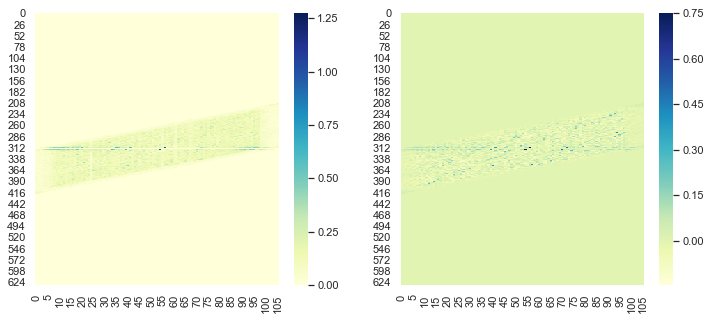

In [211]:
# %%timeit -r20

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
id_, one_hot_primary, evolutionary, coevolutionary_raw, coevolutionary, secondary = next_element

coevolutionary_raw = tf.transpose(coevolutionary_raw, (1, 2, 0, 3, 4))
coevolutionary = tf.transpose(coevolutionary, (1, 2, 0))

# ------------------------------------------
receptive_field = 105 * 3
# this assumes that the batches are padded the same along all num_steps axes
batch_size = tf.shape(coevolutionary)[0]
indices = tf.cast(tf.range(batch_size), tf.int32)

def get_receptive_field(inp, field):
    """ - assumes the (col, row, batch, ...) shape
        - pads/truncates the first dimension (col)
        such that len(col)-1 / 2 == field. col should 
        always be odd (seq_len * 2 - 1)
    """
    def _pad():
        num_dims = tf.shape(tf.shape(inp))[0]
        pad = tf.zeros((num_dims - 1, 2))
        diff = field - tf.cast((tf.shape(inp)[0] - 1) / 2, tf.int32)
        pad = tf.concat([[[diff, diff]], pad], axis=0)
        pad = tf.cast(pad, tf.int32)
        return tf.pad(inp, pad)
    
    def _truncate():
        diff = tf.cast((tf.shape(inp)[0] - 1) / 2, tf.int32) - field
        return inp[diff:-1 * diff]
    
    seq_len = tf.cast((tf.shape(inp)[0] - 1) / 2, tf.int32)
    return tf.case({
            tf.less(   field, seq_len): _truncate,
            tf.greater(field, seq_len): _pad
        }, default=lambda: inp, exclusive=True)
    
# ------------------------------------------
coevo_r = tf.pad(coevolutionary_raw, [[batch_size - 1, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

# need to throw the column out front so that is the dimension mapped over
inputs = (-1 * indices, tf.transpose(coevo_r, (1, 0, 2, 3, 4)))
fn = lambda i, col: tf.roll(col, i, axis=0)
coevo_r = tf.map_fn(lambda inp: fn(*inp), inputs, dtype=tf.float32)
coevo_r = tf.transpose(coevo_r, (1, 0, 2, 3, 4))

coevo_r = get_receptive_field(coevo_r, receptive_field)
# ------------------------------------------
coevo = tf.pad(coevolutionary, [[batch_size - 1, 0], [0, 0], [0, 0]])

# need to throw the column out front so that is the dimension mapped over
inputs = (-1 * indices, tf.transpose(coevo, (1, 0, 2)))
fn = lambda i, col: tf.roll(col, i, axis=0)
coevo = tf.map_fn(lambda inp: fn(*inp), inputs, dtype=tf.float32)
coevo = tf.transpose(coevo, (1, 0, 2))

coevo = get_receptive_field(coevo, receptive_field)
# ------------------------------------------
coevo_r_out, coevo_out = sess.run((coevo_r, coevo))
print('<')
print(coevo_r_out.shape)
print(coevo_out.shape)

coevo_raw_plt = np.max(np.max(coevo_r_out[:, :, 0], axis=-1), axis=-1)
coevo_plt = coevo_out[:, :, 0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
sns.heatmap(coevo_raw_plt, cmap='YlGnBu', ax=ax1)
sns.heatmap(coevo_plt, cmap='YlGnBu', ax=ax2)

In [200]:
%%timeit -r20

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
id_, one_hot_primary, evolutionary, coevolutionary_raw, coevolutionary, secondary = next_element

coevolutionary_raw = tf.transpose(coevolutionary_raw, (1, 2, 0, 3, 4))
coevolutionary = tf.transpose(coevolutionary, (1, 2, 0))

coevo_r, coevo = coevolutionary_raw, coevolutionary

coevo_r_out, coevo_out = sess.run((coevo_r, coevo))

5.28 s ± 78.6 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


# Tile to x3 and process

In [214]:
%%timeit -r20

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
id_, one_hot_primary, evolutionary, coevolutionary_raw, coevolutionary, secondary = next_element

coevolutionary_raw = tf.transpose(coevolutionary_raw, (1, 2, 0, 3, 4))
coevolutionary_raw = tf.tile(coevolutionary_raw,      (3, 3, 1, 1, 1))
coevolutionary = tf.transpose(coevolutionary, (1, 2, 0))
coevolutionary = tf.tile(coevolutionary,      (3, 3, 1))


# ------------------------------------------
receptive_field = 105 * 3
# this assumes that the batches are padded the same along all num_steps axes
batch_size = tf.shape(coevolutionary)[0]
indices = tf.cast(tf.range(batch_size), tf.int32)

def get_receptive_field(inp, field):
    """ - assumes the (col, row, batch, ...) shape
        - pads/truncates the first dimension (col)
        such that len(col)-1 / 2 == field. col should 
        always be odd (seq_len * 2 - 1)
    """
    def _pad():
        num_dims = tf.shape(tf.shape(inp))[0]
        pad = tf.zeros((num_dims - 1, 2))
        diff = field - tf.cast((tf.shape(inp)[0] - 1) / 2, tf.int32)
        pad = tf.concat([[[diff, diff]], pad], axis=0)
        pad = tf.cast(pad, tf.int32)
        return tf.pad(inp, pad)
    
    def _truncate():
        diff = tf.cast((tf.shape(inp)[0] - 1) / 2, tf.int32) - field
        return inp[diff:-1 * diff]
    
    seq_len = tf.cast((tf.shape(inp)[0] - 1) / 2, tf.int32)
    return tf.case({
            tf.less(   field, seq_len): _truncate,
            tf.greater(field, seq_len): _pad
        }, default=lambda: inp, exclusive=True)
    
# ------------------------------------------
coevo_r = tf.pad(coevolutionary_raw, [[batch_size - 1, 0], [0, 0], [0, 0], [0, 0], [0, 0]])

# need to throw the column out front so that is the dimension mapped over
inputs = (-1 * indices, tf.transpose(coevo_r, (1, 0, 2, 3, 4)))
fn = lambda i, col: tf.roll(col, i, axis=0)
coevo_r = tf.map_fn(lambda inp: fn(*inp), inputs, dtype=tf.float32)
coevo_r = tf.transpose(coevo_r, (1, 0, 2, 3, 4))

coevo_r = get_receptive_field(coevo_r, receptive_field)
# ------------------------------------------
coevo = tf.pad(coevolutionary, [[batch_size - 1, 0], [0, 0], [0, 0]])

# need to throw the column out front so that is the dimension mapped over
inputs = (-1 * indices, tf.transpose(coevo, (1, 0, 2)))
fn = lambda i, col: tf.roll(col, i, axis=0)
coevo = tf.map_fn(lambda inp: fn(*inp), inputs, dtype=tf.float32)
coevo = tf.transpose(coevo, (1, 0, 2))

coevo = get_receptive_field(coevo, receptive_field)
# ------------------------------------------
coevo_r_out, coevo_out = sess.run((coevo_r, coevo))
# print('<')
# print(coevo_r_out.shape)
# print(coevo_out.shape)

# coevo_raw_plt = np.max(np.max(coevo_r_out[:, :, 0], axis=-1), axis=-1)
# coevo_plt = coevo_out[:, :, 0]

# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
# sns.heatmap(coevo_raw_plt, cmap='YlGnBu', ax=ax1)
# sns.heatmap(coevo_plt, cmap='YlGnBu', ax=ax2)

3.58 s ± 866 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


In [215]:
%%timeit -r20

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
id_, one_hot_primary, evolutionary, coevolutionary_raw, coevolutionary, secondary = next_element

coevolutionary_raw = tf.transpose(coevolutionary_raw, (1, 2, 0, 3, 4))
coevolutionary_raw = tf.tile(coevolutionary_raw,      (3, 3, 1, 1, 1))
coevolutionary = tf.transpose(coevolutionary, (1, 2, 0))
coevolutionary = tf.tile(coevolutionary,      (3, 3, 1))
coevo_r, coevo = coevolutionary_raw, coevolutionary

coevo_r_out, coevo_out = sess.run((coevo_r, coevo))

2.08 s ± 146 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)
